In [1]:
import random
import numpy as np
from deap import base, creator, tools, algorithms
import networkx as nx

In [2]:
stations = ['A', 'B', 'C', 'D', 'E', 'S1', 'S2']
transitions = {
    'S1': ['A', 'B', 'C'],
    'S2': ['A', 'B', 'C', 'D', 'E']
}

In [3]:
G = nx.Graph()

for key, value in transitions.items():
    for val in value:
        G.add_edge(key, val)

{'S1': Text(-0.7017608099990026, -0.49296992287187025, 'S1'),
 'A': Text(-0.6182501822804963, 0.19171727194767452, 'A'),
 'B': Text(-0.03421880820305773, -0.6497085118622301, 'B'),
 'C': Text(-0.2921951431132157, -0.21171547185568487, 'C'),
 'S2': Text(0.19872308768631777, 0.13638949150490362, 'S2'),
 'D': Text(0.9999999999999999, 0.12858750924647702, 'D'),
 'E': Text(0.447701855909455, 0.8976996338907296, 'E')}

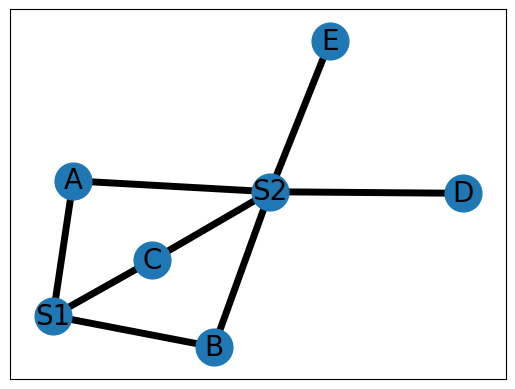

In [4]:
pos = nx.spring_layout(G, seed=1)
nx.draw_networkx_nodes(G, pos, node_size=700)
nx.draw_networkx_edges(G, pos, width=5)
nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

In [12]:
vagon_type = ['A', 'B', 'C']
lacomotive_type = ['S1', 'S2']

vagon_list = [
    {
        'st': 'A',
        'type': 'A',
    },
    {
        'st': 'A',
        'type': 'B',
    },
    {
        'st': 'A',
        'type': 'A',
    },
    {
        'st': 'A',
        'type': 'B',
    },
    {
        'st': 'A',
        'type': 'B',
    },
    {
        'st': 'A',
        'type': 'A',
    },
    {
        'st': 'B',
        'type': 'B',
    },
    {
        'st': 'B',
        'type': 'C',
    },
    {
        'st': 'B',
        'type': 'B',
    },
    {
        'st': 'C',
        'type': 'A',
    },
    {
        'st': 'C',
        'type': 'B',
    },
    {
        'st': 'C',
        'type': 'B',
    },
    {
        'st': 'D',
        'type': 'A',
    },
    {
        'st': 'D',
        'type': 'B',
    },
    {
        'st': 'E',
        'type': 'B',
    },
    {
        'st': 'E',
        'type': 'A',
    },
    {
        'st': 'E',
        'type': 'A',
    },
]

In [6]:
# 0 - простой
# 1 - перевести на другую ветку
# 2 - присоединить вагон
# 3 - отсоединить вагон

operations_cost = [10, 15, 2, 2]

In [10]:
VAGON_COUNT = 17
MAX_OPERATIONS = 20
LENGTH_CHROM = VAGON_COUNT * MAX_OPERATIONS     # длина хромосомы, подлежащей оптимизации
TRAIN_LIVE_TIME = {
    'S1': 5,
    'S2': 10
}
 
# константы генетического алгоритма
POPULATION_SIZE = 500   # количество индивидуумов в популяции
P_CROSSOVER = 0.9       # вероятность скрещивания
P_MUTATION = 0.1        # вероятность мутации индивидуума
MAX_GENERATIONS = 30    # максимальное количество поколений

In [8]:
RANDOM_SEED = 0
random.seed(RANDOM_SEED)

In [9]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [13]:
def create_random_list(max_range, count):
    operations_count = random.randint(1, count)
    r = []
    for _ in range(count):
        if operations_count > 0:
            new_oper = random.randint(0, max_range)
            if new_oper == 1:
                state = random.choice(['A', 'B', 'C', 'D', 'E', 'S1', 'S2'])
                r.append({f'{new_oper}': state})
            else:
                r.append({f'{new_oper}': None})
        else:
            r.append({'0': None})
        operations_count -= 1
    return r

In [11]:
create_random_list(4, 20)

[{'3': None},
 {'0': None},
 {'2': None},
 {'4': None},
 {'3': None},
 {'3': None},
 {'2': None},
 {'3': None},
 {'2': None},
 {'4': None},
 {'1': 'E'},
 {'1': 'C'},
 {'1': 'S2'},
 {'0': None},
 {'0': None},
 {'0': None},
 {'0': None},
 {'0': None},
 {'0': None},
 {'0': None}]

In [14]:
toolbox = base.Toolbox()
toolbox.register("randomOper", create_random_list, len(operations_cost) - 1, MAX_OPERATIONS)
toolbox.register("individualCreator", tools.initRepeat, creator.Individual, toolbox.randomOper, len(vagon_list))
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

In [15]:
population = toolbox.populationCreator(n=POPULATION_SIZE)

In [16]:
def shedule_cost(individual):
    current_cost = 0
    for vagon_id in range(len(individual)):
        for curr_vagon in individual[vagon_id]:
            is_in_lacomotive = True if vagon_list[vagon_id]['st'] in ['S1', 'S2'] else False
            for key, val in curr_vagon.items():
                if key == '0' and is_in_lacomotive:
                    current_cost += 0
                else:
                    current_cost += operations_cost[int(key)]
    return current_cost,

In [17]:
def mate(ind1, ind2):
    
    ind1[:(VAGON_COUNT//2)], ind2[:(VAGON_COUNT//2)] = ind2[:(VAGON_COUNT//2)], ind1[:(VAGON_COUNT//2)]
    return ind1, ind2

In [18]:
def mut(individual, indpb):
    for ind in individual:
        tools.mutShuffleIndexes(ind, indpb)
 
    return individual,

In [21]:
toolbox.register("evaluate", shedule_cost)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", mate)
toolbox.register("mutate", mut, indpb=1.0/LENGTH_CHROM/10)

In [22]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)

In [23]:
population, logbook = algorithms.eaSimple(population, toolbox,
                                        cxpb=P_CROSSOVER/VAGON_COUNT,
                                        mutpb=P_MUTATION/VAGON_COUNT,
                                        ngen=MAX_GENERATIONS,
                                        stats=stats,
                                        verbose=True)

gen	nevals	min 	avg    
0  	500   	2621	2912.31
1  	31    	2621	2841.24
2  	26    	2621	2782.51
3  	27    	2621	2734.15
4  	24    	2621	2700.28
5  	36    	2606	2673.7 
6  	31    	2606	2643.99
7  	25    	2606	2623.11
8  	22    	2606	2616.92
9  	24    	2606	2611.97
10 	32    	2606	2608.09
11 	22    	2606	2607.17
12 	31    	2606	2606.43
13 	28    	2606	2606.02
14 	30    	2606	2606   
15 	42    	2606	2606   
16 	32    	2606	2606   
17 	26    	2606	2606   
18 	22    	2606	2606   
19 	26    	2606	2606   
20 	41    	2606	2606   
21 	35    	2606	2606   
22 	43    	2606	2606   
23 	22    	2606	2606   
24 	20    	2606	2606   
25 	29    	2606	2606   
26 	38    	2606	2606   
27 	39    	2606	2606   
28 	36    	2606	2606   
29 	25    	2606	2606   
30 	22    	2606	2606   


In [24]:
maxFitnessValues, meanFitnessValues = logbook.select("min", "avg")

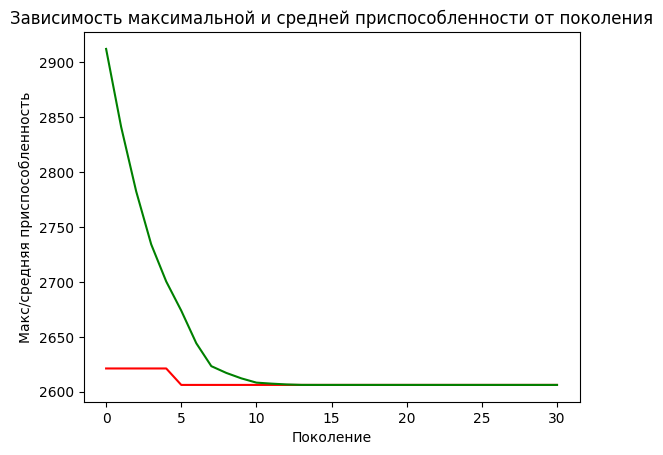

In [25]:
import matplotlib.pyplot as plt

plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Поколение')
plt.ylabel('Макс/средняя приспособленность')
plt.title('Зависимость максимальной и средней приспособленности от поколения')
 
plt.show()

In [26]:
for vagon in population[0]:
    print(vagon)

[{'3': None}, {'2': None}, {'3': None}, {'1': 'D'}, {'0': None}, {'2': None}, {'2': None}, {'3': None}, {'2': None}, {'1': 'D'}, {'1': 'B'}, {'0': None}, {'1': 'D'}, {'0': None}, {'2': None}, {'2': None}, {'1': 'B'}, {'0': None}, {'2': None}, {'0': None}]
[{'3': None}, {'2': None}, {'0': None}, {'3': None}, {'0': None}, {'0': None}, {'3': None}, {'3': None}, {'0': None}, {'1': 'A'}, {'1': 'S2'}, {'1': 'B'}, {'3': None}, {'0': None}, {'0': None}, {'0': None}, {'0': None}, {'0': None}, {'0': None}, {'0': None}]
[{'3': None}, {'0': None}, {'2': None}, {'2': None}, {'1': 'A'}, {'3': None}, {'3': None}, {'0': None}, {'1': 'S2'}, {'2': None}, {'3': None}, {'2': None}, {'3': None}, {'3': None}, {'1': 'S2'}, {'0': None}, {'0': None}, {'0': None}, {'0': None}, {'0': None}]
[{'0': None}, {'2': None}, {'1': 'E'}, {'3': None}, {'1': 'B'}, {'3': None}, {'1': 'D'}, {'2': None}, {'3': None}, {'3': None}, {'0': None}, {'0': None}, {'0': None}, {'0': None}, {'0': None}, {'0': None}, {'0': None}, {'0': 